In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from keras import Sequential
from keras.layers import Dense, LSTM
import tensorflow as tf
import keras

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import MinMaxScaler

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX




from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Conv1D, Conv2D, MaxPooling1D, Flatten
from keras.layers import GRU

import numpy as np

Using TensorFlow backend.
/usr/local/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:

df = pd.read_csv('re_fixed_multivariate_timeseires.csv')
df.drop(df.loc[df['datetime'].duplicated()].index, inplace = True)
df['datetime'] = pd.to_datetime(df['datetime'])

# df = df.sort_values(df['datetime'], ascending=[True])


df.set_index(df['datetime'], inplace = True)
df.drop(columns = [ 'datetime'], inplace = True)

In [3]:
steps=24
dataset_for_prediction= df.copy()
dataset_for_prediction['Actual']=dataset_for_prediction['GBP/mWh'].shift(-steps)
dataset_for_prediction=dataset_for_prediction.dropna()


,GBP/mWh,temperature,coal Price,oil Price,uranium Price,natural gas Price,Actual
datetime,,,,,,,
2013-01-01 01:00:00,37.76,48.48,95.59,111.11,43.5,3.351,31.31
2013-01-01 02:00:00,30.01,48.30,95.59,111.11,43.5,3.351,28.91
2013-01-01 03:00:00,21.98,46.40,95.59,111.11,43.5,3.351,28.03


### Scaling inputs and outpust seperately

In [6]:
sc_in = MinMaxScaler(feature_range=(0, 1))
scaled_input = sc_in.fit_transform(dataset_for_prediction[['GBP/mWh', 'temperature','coal Price','oil Price', 'uranium Price','natural gas Price','Actual']])
scaled_input =pd.DataFrame(scaled_input)
X= scaled_input

sc_out = MinMaxScaler(feature_range=(0, 1))
scaler_output = sc_out.fit_transform(dataset_for_prediction[['Actual']])
scaler_output =pd.DataFrame(scaler_output)
y=scaler_output

In [8]:
list( dataset_for_prediction.columns)

['GBP/mWh',
 'temperature',
 'coal Price',
 'oil Price',
 'uranium Price',
 'natural gas Price',
 'Actual']

In [9]:
X.rename(columns = {0:'GBP/mWh',
 1:'temperature',
 2:'coal Price',
 3:'oil Price',
 4:'uranium Price',
 5:'natural gas Price',
 6:'Actual'}, inplace = True)

In [10]:
X.index = dataset_for_prediction.index
X.drop(columns = 'Actual', inplace = True)

y.rename(columns={0:'Electricity price in 24 hours'}, inplace= True)
y.index=dataset_for_prediction.index

In [93]:
train_X, train_y = X[24:52560], y[24:52560] 
test_X, test_y = X[52560:].dropna(), y[52560:].dropna()

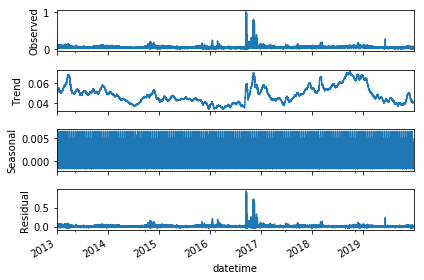

In [15]:
seas_d=sm.tsa.seasonal_decompose(X['GBP/mWh'],model='add',freq=365);
fig=seas_d.plot()
fig.set_figheight(4)
plt.show()

In [16]:
from statsmodels.tsa.stattools import adfuller

def test_adf(series, title=''):
    dfout={}
    dftest=sm.tsa.adfuller(series.dropna(), autolag='AIC', regression='ct')
    for key,val in dftest[4].items():
        dfout['critical value {}'.format(key)]=val
    if dftest[1]<=0.05:
        print("Strong evidence against Null Hypothesis")
        print("Reject Null Hypothesis - Data is Stationary")
        print("Data is Stationary", title)
    else:
        print("Strong evidence for  Null Hypothesis")
        print("Accept Null Hypothesis - Data is not Stationary")
        print("Data is NOT Stationary for", title)
        
y_test=y['Electricity price in 24 hours'][24:43800].dropna()
test_adf(y_test, " Electricity Price")

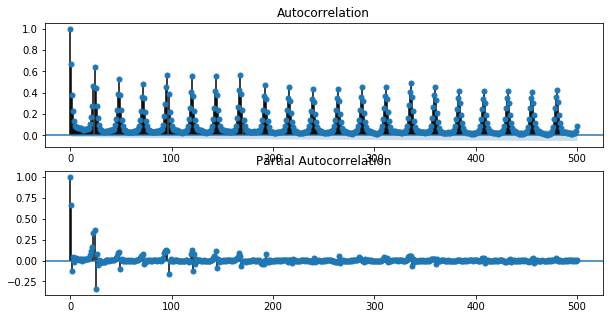

In [18]:
fig,ax= plt.subplots(2,1, figsize=(10,5))
fig=sm.tsa.graphics.plot_acf(y_test, lags=500, ax=ax[0])
fig=sm.tsa.graphics.plot_pacf(y_test, lags=500, ax=ax[1])
plt.show()

In [95]:
!sudo pip install pmdarima
from pmdarima.arima import auto_arima


In [96]:
 step_wise = auto_arima(train_y, 
     exogenous= train_X,
     start_p=0, start_q=0, 
     max_p=5, max_q=5, 
     d=1, max_d=168,
     n_jobs = -1,
     start_Q=0,
     max_P=5,
     max_D=5,
     max_Q=5,
     seasonal = True,
     stationary = True,
     trace=True, 
     error_action='ignore', 
     suppress_warnings=True, 
     random = True,
     stepwise=False)

Total fit time: 217.182 seconds


In [97]:
step_wise.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                52536
Model:               SARIMAX(1, 0, 3)   Log Likelihood              166754.843
Date:                Thu, 16 Jan 2020   AIC                        -333485.685
Time:                        10:55:01   BIC                        -333379.254
Sample:                             0   HQIC                       -333452.423
                              - 52536                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             0.0040      0.000     12.290      0.000       0.003       0.005
GBP/mWh               0.6058      0.000   2835.063      0.000       0.605       0.606
temperature           0.0023      0.001      2.651      0.008       0.001       0.004
coal Price            0.0166      0.001     12.713      0.000       0.014       0.019
oil Price            -0.0054      0.002     -3.320      0.001      -0.009      -0.002
uranium Price         0.0045      0.001      4.460      0.000       0.003       0.007
natural gas Price  6.979e-05      0.002      0.039      0.969      -0.003       0.004
ar.L1                 0.6151      0.006    102.265      0.000       0.603       0.627
ma.L1                 0.0885      0.006     14.819      0.000       0.077       0.100
ma.L2                -0.0914      0.004    -21.709      0.000      -0.100      -0.083
ma.L3                -0.0138      0.003     -4.363      0.000      -0.020      -0.008
sigma2                0.0001   2.68e-08   3867.790      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                     1060.87   Jarque-Bera (JB):        9554403178.05
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.09   Skew:                            21.00
Prob(H) (two-sided):                  0.00   Kurtosis:                      2091.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [98]:
model= SARIMAX(train_y, 
 exog=train_X,
 order=(1,0,3),
enforce_invertibility=False, enforce_stationarity=False)

/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [99]:
results=model.fit()

forecast = results.forecast(steps=8742, exog = test_X)



In [101]:
train_size = 52560
test_size = 61302
steps = -24

In [102]:
predictions= results.predict(start = 52560, end=61302+(steps)-1 ,exog=test_X)

/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [103]:
forecast_electricity= pd.DataFrame(forecast)
forecast_electricity.reset_index(drop=True, inplace=True)
forecast_electricity.index=test_X.index
forecast_electricity['Actual'] =scaler_output.iloc[43800:, 0]
forecast_electricity.rename(columns={0:'Forecast'}, inplace=True)

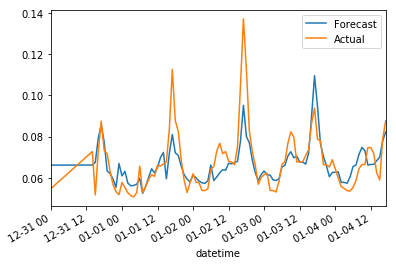

In [104]:

forecast_electricity['Forecast'][:100].plot(legend=True)
forecast_electricity['Actual'][:100].plot(legend=True)

In [105]:
from numpy import inf

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    difference = abs((y_true - y_pred))
    difference[difference == inf] = 0.01
    difference[difference == -inf] = 0.01
    difference[difference == 0] = 0.01
    y_true[y_true == 0] = 0.01
    return np.mean((difference/y_true) * 100)

In [106]:
mape = mean_absolute_percentage_error(forecast_electricity['Actual'], forecast_electricity['Forecast'])
mape

14.436116563955862

In [109]:
act= pd.DataFrame(scaler_output.iloc[train_size:, 0])


In [111]:
act.head()

,Electricity price in 24 hours
datetime,
2018-12-31 14:00:00,0.072706
2018-12-31 15:00:00,0.051645
2018-12-31 16:00:00,0.072636
2018-12-31 17:00:00,0.087519
2018-12-31 18:00:00,0.073275


In [113]:

predictions=pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True)
predictions.index=test_X[24:].index
predictions['Actual'] = act['Electricity price in 24 hours']
predictions.rename(columns={0:'Pred'}, inplace=True)

In [114]:
testPredict = sc_out.inverse_transform(predictions[['Pred']])
testActual = sc_out.inverse_transform(predictions[['Actual']])

In [130]:
testPredict = sc_out.inverse_transform(predictions[['Pred']])
testActual = sc_out.inverse_transform(predictions[['Actual']])


unscaled = pd.DataFrame(testPredict)
unscaled['actual'] = testActual
unscaled = unscaled.rename(columns={0: 'predictions'})

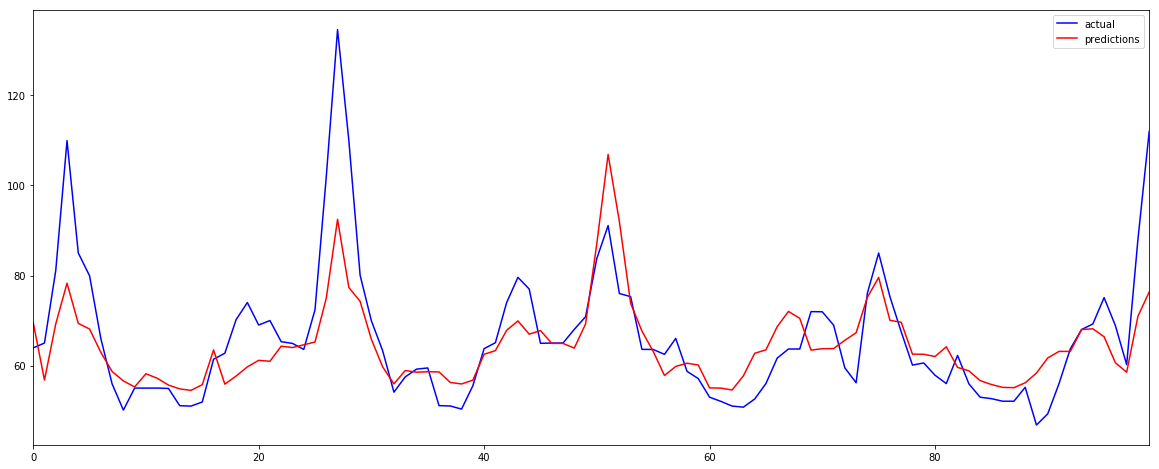

In [137]:
unscaled['actual'][:100].plot(figsize=(20,8), legend=True, color='blue')
unscaled['predictions'][:100].plot(legend=True, color='red', figsize=(20,8))

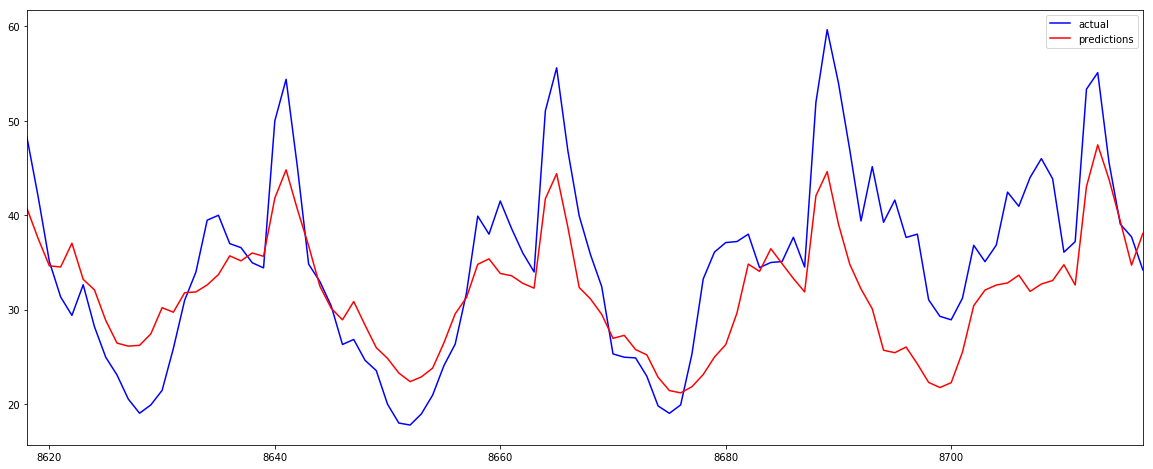

In [138]:
unscaled['actual'][-100:].plot(figsize=(20,8), legend=True, color='blue')
unscaled['predictions'][-100:].plot(legend=True, color='red', figsize=(20,8))

In [139]:
!sudo pip install xgboost

In [140]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree

In [145]:
from sklearn.model_selection import GridSearchCV
xgb1 = xgb.XGBRegressor()
parameters = { #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [100,500, 1000],
             'n_jobs' : [-1]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 5,
                        n_jobs = -1,
                        verbose=True)

xgb_grid.fit(train_X,
         train_y)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 34.2min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 151.3min finished


0.29845911309424344
{'min_child_weight': 4, 'max_depth': 6, 'n_estimators': 100, 'learning_rate': 0.05, 'colsample_bytree': 0.7, 'n_jobs': -1, 'silent': 1, 'subsample': 0.7, 'objective': 'reg:linear'}


In [151]:
xgbbest = xgb.XGBRegressor(min_child_weight = 4, max_depth = 6, n_estimators = 100, learning_rate=0.05, colsample_bytree =0.7, n_jobs = -1, silent = 1 , subsample = 0.7)
xgbbest.fit(train_X,
         train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.7, gamma=0,
       importance_type='gain', learning_rate=0.05, max_delta_step=0,
       max_depth=6, min_child_weight=4, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=1,
       subsample=0.7, verbosity=1)

In [153]:
predictionsxgb = xgbbest.predict(test_X)

In [161]:
predictionsxgb=pd.DataFrame(predictionsxgb)
predictionsxgb.reset_index(drop=True, inplace=True)
predictionsxgb.index=test_X.index
predictionsxgb['Actual'] = act['Electricity price in 24 hours']
predictionsxgb.rename(columns={0:'Pred'}, inplace=True)


In [170]:
testPredictxgb = sc_out.inverse_transform(predictions[['Pred']])
testActualxgb = sc_out.inverse_transform(predictions[['Actual']])

unscaledxgb = pd.DataFrame(testPredictxgb)
unscaledxgb['actual'] = testActualxgb
unscaledxgb = unscaledxgb.rename(columns={0: 'predictions'})



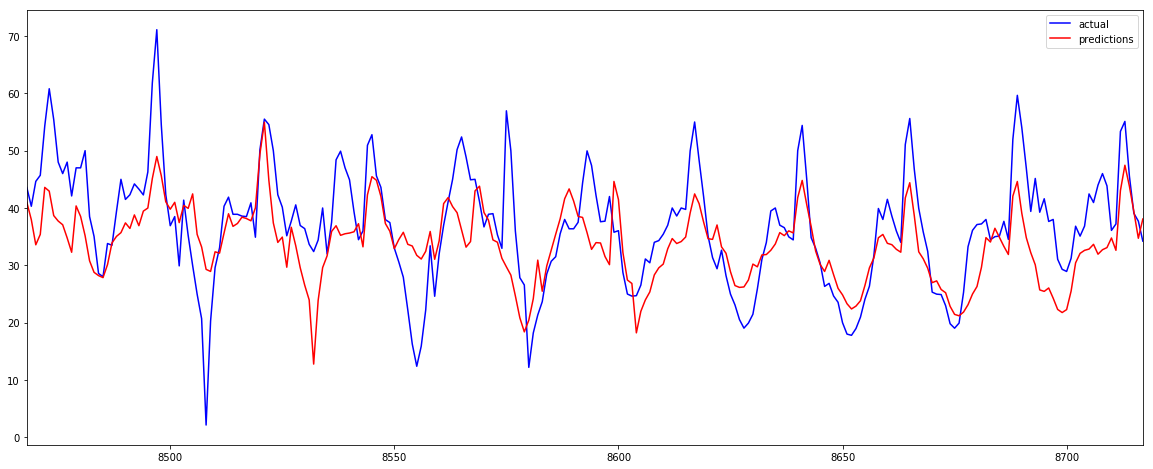

In [173]:
unscaledxgb['actual'][-250:].plot(figsize=(20,8), legend=True, color='blue')
unscaledxgb['predictions'][-250:].plot(legend=True, color='red', figsize=(20,8))

In [174]:
mape = mean_absolute_percentage_error(unscaledxgb['actual'], unscaledxgb['predictions'])
mape

146.58929021204378